# This is the Coursera capstone project (Seattle collisions data)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [3]:
#https://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0
dfOriginal = pd.read_csv('Data-Collisions.csv')

C:\Users\carniato\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Create train and test dataset

Use startified samples, to get the same distributions of targets in train and test set

In [4]:
df=dfOriginal.copy()
y = df['SEVERITYCODE']
X = df.drop(['SEVERITYCODE'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify =y)

train = pd.concat([X_train, y_train],axis=1)
test = pd.concat([X_test, y_test],axis=1)

# Data cleaning

Inspect data first

In [5]:
def computeDetails(df): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    
    cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration']
    details = pd.concat([types, counts, distincts, nulls, missing_ration], axis = 1)
    details.columns = cols
    
    return details

def GetIndexses(df,col_missing_data,missingValue):
    if not missingValue :
        # nan
        indexses = df[col_missing_data].isnull()
    else:
        # comparables
        indexses = df[col_missing_data]==missingValue
        
    return indexses

def InputMissingData(df, col_missing_data, col_ref, missingValue = None):
    #group by nan or missing value
    invalid_idxs = GetIndexses(df, col_missing_data, missingValue)
    df_notval = df[invalid_idxs]
    df_notval = df_notval.groupby(col_ref).sum()  
    #print(df_notval[col_ref])
    #the valid entries
    df_val = df[~invalid_idxs]
    
    #now check the values of the reference column
    for r in df_notval.index.values:
        if isinstance(r, str) or isinstance(r, np.int64) :
            #a string (e.g. a location)
            df_loc = df_val[df_val[col_ref]==r]
        elif len(r)==2:
            #two doubles
            df_loc = df_val[(df_val[col_ref[0]]==r[0]) & (df_val[col_ref[1]]==r[1])]
        
        if len(df_loc) > 0:
            val = df_loc[col_missing_data].iloc[0]
            if isinstance(r, str) or isinstance(r, np.int64) :
                #substitute with the first valid value
                df.loc[(df[col_ref]==r) & invalid_idxs,col_missing_data]=val
            elif len(r) ==2:
                df.loc[(df[col_ref[0]]==r[0]) &(df[col_ref[1]]==r[1]) & invalid_idxs, col_missing_data] = val
        
    return df     

from scipy import stats
from statsmodels.stats import weightstats as stests

def bar_chart(datafr, feature):
    # z-test
    grp1 = datafr[datafr['SEVERITYCODE']==1][feature]
    grp2 =datafr[datafr['SEVERITYCODE']==2][feature]        
    #bar chart
    severityOne = grp1.value_counts()
    #print(severityOne[0]/(severityOne[0] + severityOne[1]))
    severityTwo = grp2.value_counts()
    #print(severityTwo[0]/(severityTwo[0] + severityTwo[1]))
    df = pd.DataFrame([severityOne,severityTwo])
    df.index = ['SEVERITYCODE 1','SEVERITYCODE 2']
    df.plot(kind='bar',stacked=True, figsize=(10,5))
    
from sklearn.preprocessing import LabelEncoder
def prepare_categorical(train_label, test_label):
    le = LabelEncoder()
    le.fit(train_label)
    train_label_enc = le.transform(train_label)
    test_label_enc = le.transform(test_label)
    return train_label_enc, test_label_enc


def CalculateZTest(datafr, feature):
    grp1 = datafr[datafr['SEVERITYCODE']==1][feature]
    grp2 =datafr[datafr['SEVERITYCODE']==2][feature]
    ztest ,pval = stests.ztest(grp1, x2=grp2, value=0,alternative='two-sided')
    if pval<0.05:
        print("reject null hypothesis, groups are different, pval ", float(pval))
    else:
        print("accept null hypothesis, groups are not different, pval", float(pval))

In [6]:
details = computeDetails(train)
print(details)

                  types  counts  distincts   nulls  missing ration
X               float64  126901      20954    3529           2.706
Y               float64  126901      21200    3529           2.706
OBJECTID          int64  130430     130430       0           0.000
INCKEY            int64  130430     130430       0           0.000
COLDETKEY         int64  130430     130430       0           0.000
REPORTNO         object  130430     130428       0           0.000
STATUS           object  130430          2       0           0.000
ADDRTYPE         object  129162          4    1268           0.972
INTKEY          float64   43707       6732   86723          66.490
LOCATION         object  128674      21416    1756           1.346
EXCEPTRSNCODE    object   56823          3   73607          56.434
EXCEPTRSNDESC    object    3792          2  126638          97.093
SEVERITYCODE.1    int64  130430          2       0           0.000
SEVERITYDESC     object  130430          2       0           0

# Drop features with duplicate information or features only containing administrative information

In [7]:
admin_columns = ['REPORTNO', 'COLLISIONTYPE','ST_COLCODE','ST_COLDESC','SDOT_COLCODE','SDOTCOLNUM','SDOT_COLDESC',
              'OBJECTID','INCKEY','COLDETKEY','STATUS','COLLISIONTYPE','INTKEY','LOCATION','INATTENTIONIND','UNDERINFL',
                'PEDROWNOTGRNT']

train = train.drop(admin_columns,axis=1)
test = test.drop(admin_columns,axis=1)

# Use X,Y for filling missing JUNCTIONTYPE

In [8]:
train = InputMissingData(train, 'JUNCTIONTYPE', ['X','Y'])
test = InputMissingData(test, 'JUNCTIONTYPE', ['X','Y'])

# Save dataframe

In [9]:
train.to_csv('Data-Collisions-raw-train.csv')
test.to_csv('Data-Collisions-raw-test.csv')

# Load dataframe

In [10]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [11]:
train = pd.read_csv('Data-Collisions-raw-train.csv')
train = train.drop(['Unnamed: 0'], axis=1)

In [12]:
test = pd.read_csv('Data-Collisions-raw-test.csv')
test = test.drop(['Unnamed: 0'], axis=1)

# Drop selected features

Eliminate features identical to the target or containing the same type of information.

In [13]:
train = train.drop(['SEVERITYCODE.1'], axis=1)
test = test.drop(['SEVERITYCODE.1'], axis=1)

train = train.drop(['SEVERITYDESC'], axis=1)
test = test.drop(['SEVERITYDESC'], axis=1)

Eliminate EXCEPTRSNDESC, not enough information

In [14]:
train['EXCEPTRSNDESC'].value_counts()

Not Enough Information, or Insufficient Location Information    3792
Name: EXCEPTRSNDESC, dtype: int64

In [15]:
train = train.drop(['EXCEPTRSNDESC'], axis=1)
test = test.drop(['EXCEPTRSNDESC'], axis=1)

EXCEPTRSNCODE has no descriptive field, we do not know what it is 

In [16]:
train['EXCEPTRSNCODE'].value_counts()

       53031
NEI     3792
Name: EXCEPTRSNCODE, dtype: int64

In [17]:
train = train.drop(['EXCEPTRSNCODE'], axis=1)
test = test.drop(['EXCEPTRSNCODE'], axis=1)

# Replace missing values

In [18]:
details = computeDetails(train)
print(details)

details = computeDetails(test)
print(details)

                types  counts  distincts   nulls  missing ration
X             float64  126901      20954    3529           2.706
Y             float64  126901      21200    3529           2.706
ADDRTYPE       object  129162          4    1268           0.972
PERSONCOUNT     int64  130430         44       0           0.000
PEDCOUNT        int64  130430          6       0           0.000
PEDCYLCOUNT     int64  130430          3       0           0.000
VEHCOUNT        int64  130430         12       0           0.000
INCDATE        object  130430       5983       0           0.000
INCDTTM        object  130430     109974       0           0.000
JUNCTIONTYPE   object  128733          8    1697           1.301
WEATHER        object  126977         12    3453           2.647
ROADCOND       object  127022         10    3408           2.613
LIGHTCOND      object  126926         10    3504           2.686
SPEEDING       object    6271          2  124159          95.192
SEGLANEKEY      int64  13

INATTENTIONIND id contain only yes, suppose the other equal to n

In [19]:
#train['INATTENTIONIND'].value_counts()

In [20]:
#train['INATTENTIONIND'] = train['INATTENTIONIND'].replace(np.nan,0)
#train['INATTENTIONIND'] = train['INATTENTIONIND'].replace('Y',1)
#train['INATTENTIONIND'].value_counts()

#test['INATTENTIONIND'] = test['INATTENTIONIND'].replace(np.nan,0)
#test['INATTENTIONIND'] = test['INATTENTIONIND'].replace('Y',1)

In [21]:
#train['PEDROWNOTGRNT'].value_counts()

In [22]:
#train['PEDROWNOTGRNT'] = train['PEDROWNOTGRNT'].replace(np.nan,0)
#test['PEDROWNOTGRNT'] = test['PEDROWNOTGRNT'].replace(np.nan,0)

#train['PEDROWNOTGRNT'] = train['PEDROWNOTGRNT'].replace('Y',1)
#test['PEDROWNOTGRNT'] = test['PEDROWNOTGRNT'].replace('Y',1)

In [23]:
train['SPEEDING'].value_counts()

Y    6271
Name: SPEEDING, dtype: int64

In [24]:
train['SPEEDING'] = train['SPEEDING'].replace(np.nan,0)
test['SPEEDING'] = test['SPEEDING'].replace(np.nan,0)

train['SPEEDING'] = train['SPEEDING'].replace('Y',1)
test['SPEEDING'] = test['SPEEDING'].replace('Y',1)

In [25]:
#train['UNDERINFL'].value_counts()

In [26]:
#train['UNDERINFL'] = train['UNDERINFL'].replace('N',0)
#train['UNDERINFL'] = train['UNDERINFL'].replace('Y',1)  
#train['UNDERINFL'] = train['UNDERINFL'].replace('0',0) 
#train['UNDERINFL'] = train['UNDERINFL'].replace('1',1) 

#test['UNDERINFL'] = test['UNDERINFL'].replace('N',0)
#test['UNDERINFL'] = test['UNDERINFL'].replace('Y',1)  
#test['UNDERINFL'] = test['UNDERINFL'].replace('0',0) 
#test['UNDERINFL'] = test['UNDERINFL'].replace('1',1) 

In [27]:
#bar_chart(train, 'UNDERINFL')

In [28]:
train['LIGHTCOND'].value_counts()

Daylight                    77783
Dark - Street Lights On     32401
Unknown                      9092
Dusk                         3994
Dawn                         1669
Dark - No Street Lights      1015
Dark - Street Lights Off      809
Other                         155
Dark - Unknown Lighting         8
Name: LIGHTCOND, dtype: int64

In [29]:
train['LIGHTCOND'] = train['LIGHTCOND'].replace(np.nan,'Unknown')
test['LIGHTCOND'] = test['LIGHTCOND'].replace(np.nan,'Unknown')

In [30]:
train['ROADCOND'].value_counts()

Dry               83405
Wet               31687
Unknown           10173
Ice                 812
Snow/Slush          691
Other                84
Standing Water       79
Sand/Mud/Dirt        51
Oil                  40
Name: ROADCOND, dtype: int64

In [31]:
train['ROADCOND'] = train['ROADCOND'].replace(np.nan,'Unknown')
test['ROADCOND'] = test['ROADCOND'].replace(np.nan,'Unknown')

In [32]:
train['WEATHER'].value_counts()

Clear                       74348
Raining                     22215
Overcast                    18541
Unknown                     10177
Snowing                       619
Other                         557
Fog/Smog/Smoke                387
Sleet/Hail/Freezing Rain       75
Blowing Sand/Dirt              36
Severe Crosswind               17
Partly Cloudy                   5
Name: WEATHER, dtype: int64

In [33]:
train['WEATHER'] = train['WEATHER'].replace(np.nan,'Unknown')
test['WEATHER'] = test['WEATHER'].replace(np.nan,'Unknown')

# Treat dates

INCDATE contains the date of collision, it is already contained in INCDTTM

In [34]:
train['INCDTTM'] = pd.to_datetime(train['INCDTTM'])
test['INCDTTM'] = pd.to_datetime(test['INCDTTM'])

In [35]:
train = train.drop(['INCDATE'], axis=1)
test = test.drop(['INCDATE'], axis=1)

Check incidents by hour

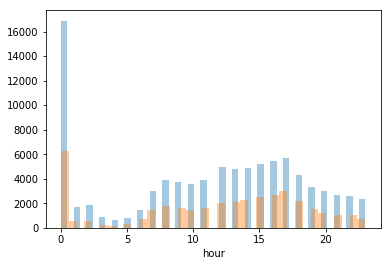

In [36]:
train['hour'] = train['INCDTTM'].dt.hour
test['hour'] = test['INCDTTM'].dt.hour

df_selected = train[train['SEVERITYCODE']==1]
sns.distplot(df_selected['hour'],kde = False)

df_selected = train[train['SEVERITYCODE']==2]
sns.distplot(df_selected['hour'],kde = False)

Check day of the week

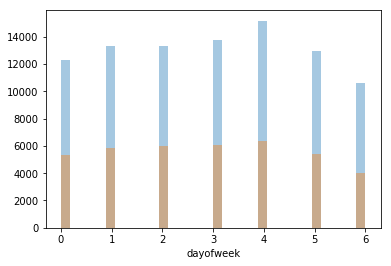

In [37]:
train['dayofweek'] = train['INCDTTM'].dt.dayofweek
test['dayofweek'] = test['INCDTTM'].dt.dayofweek

df_selected = train[train['SEVERITYCODE']==1]
sns.distplot(df_selected['dayofweek'],kde = False)
df_selected = train[train['SEVERITYCODE']==2]
sns.distplot(df_selected['dayofweek'],kde = False)

Check month

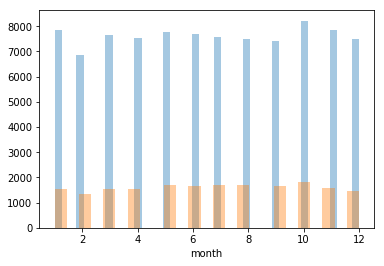

In [38]:
train['month'] = train['INCDTTM'].dt.month
test['month'] = test['INCDTTM'].dt.month

df_selected = train[train['SEVERITYCODE']==1]
sns.distplot(df_selected['month'],kde = False)
df_selected = test[test['SEVERITYCODE']==2]
sns.distplot(df_selected['month'],kde = False)

Check year

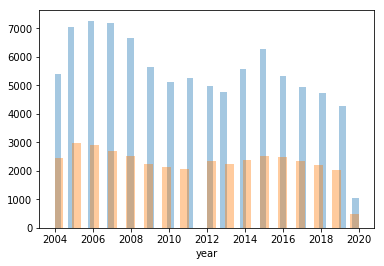

In [39]:
train['year'] = train['INCDTTM'].dt.year
test['year'] = test['INCDTTM'].dt.year

df_selected = train[train['SEVERITYCODE']==1]
sns.distplot(df_selected['year'],kde = False)
df_selected = train[train['SEVERITYCODE']==2]
sns.distplot(df_selected['year'],kde = False)

Remove INCDTTM after saving dayofweek, month, hours, year

In [40]:
train = train.drop(['INCDTTM'], axis=1)
test = test.drop(['INCDTTM'], axis=1)

# Check outliers

In [41]:
details = computeDetails(train)
print(details)

                types  counts  distincts  nulls  missing ration
X             float64  126901      20954   3529           2.706
Y             float64  126901      21200   3529           2.706
ADDRTYPE       object  129162          4   1268           0.972
PERSONCOUNT     int64  130430         44      0           0.000
PEDCOUNT        int64  130430          6      0           0.000
PEDCYLCOUNT     int64  130430          3      0           0.000
VEHCOUNT        int64  130430         12      0           0.000
JUNCTIONTYPE   object  128733          8   1697           1.301
WEATHER        object  130430         11      0           0.000
ROADCOND       object  130430          9      0           0.000
LIGHTCOND      object  130430          9      0           0.000
SPEEDING        int64  130430          2      0           0.000
SEGLANEKEY      int64  130430       1432      0           0.000
CROSSWALKKEY    int64  130430       1704      0           0.000
HITPARKEDCAR   object  130430          2

PERSONCOUNT   0   81
2     76565
3     23735
4      9859
1      8768
5      4453
0      3732
6      1828
7       759
8       345
9       150
10       86
11       34
12       17
13       15
14       10
15        9
17        7
16        6
44        5
19        4
26        4
18        3
20        3
47        3
34        3
22        2
23        2
24        2
25        2
29        2
21        2
32        2
36        2
54        1
37        1
43        1
41        1
39        1
30        1
31        1
28        1
27        1
81        1
57        1
Name: PERSONCOUNT, dtype: int64
PEDCOUNT   0   6
0    125818
1      4442
2       150
3        15
4         4
6         1
Name: PEDCOUNT, dtype: int64
PEDCYLCOUNT   0   2
0    126705
1      3700
2        25
Name: PEDCYLCOUNT, dtype: int64
VEHCOUNT   0   11
2     98861
1     17238
3      8721
0      3455
4      1666
5       342
6        96
7        30
8        10
9         7
11        3
10        1
Name: VEHCOUNT, dtype: int64
SEGLANEKEY   0   52524

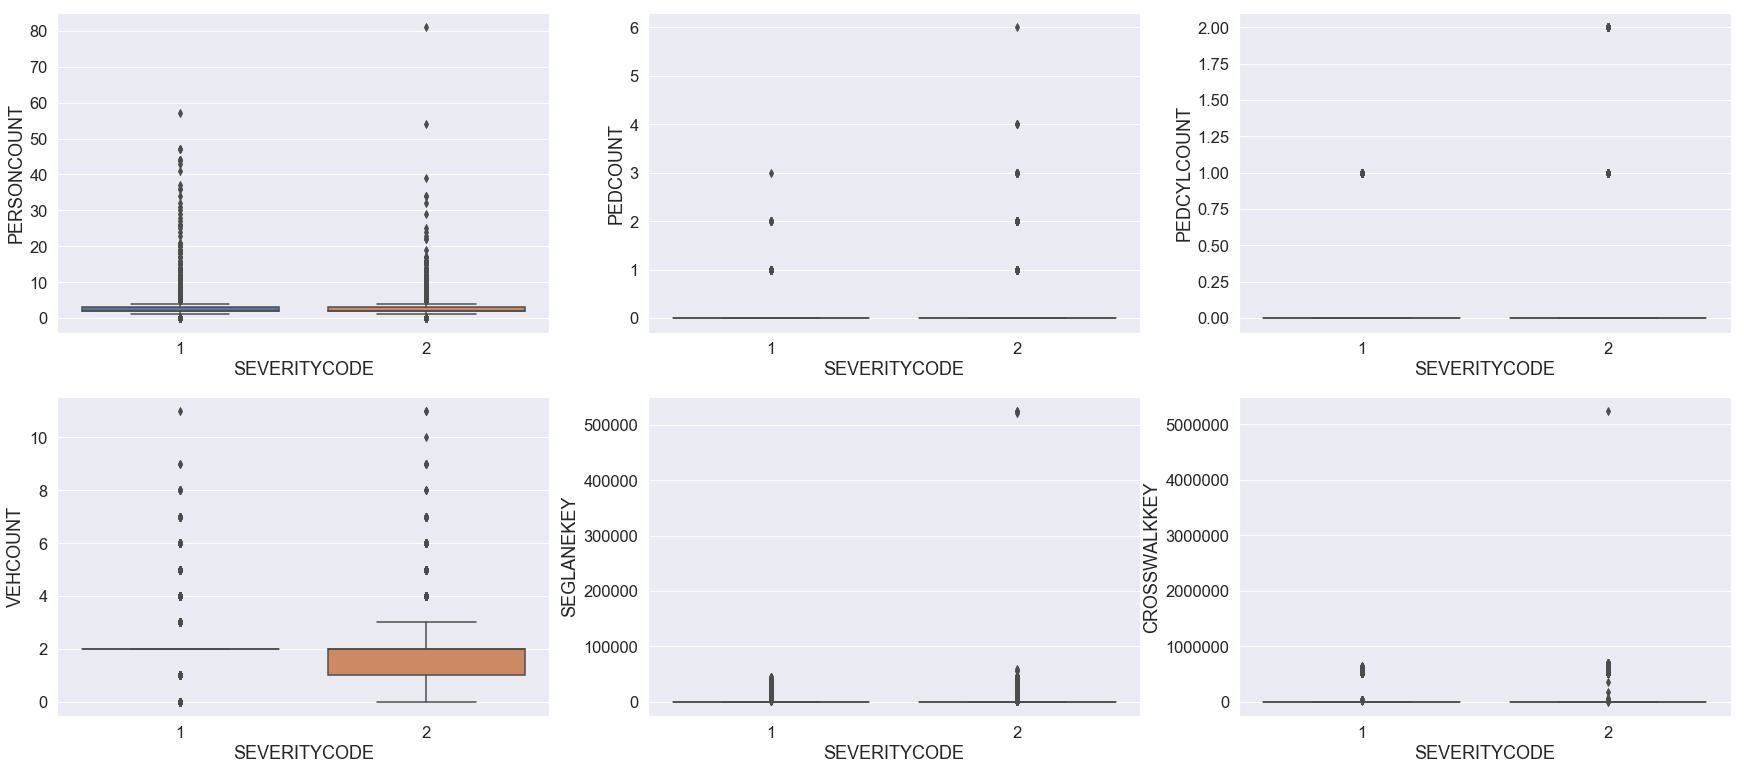

In [42]:
fig = plt.figure(figsize=(30, 20))
sns.set(font_scale=1.5)
key='PERSONCOUNT'
fig1 = fig.add_subplot(331); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='PEDCOUNT'
fig1 = fig.add_subplot(332); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())


key='PEDCYLCOUNT'
fig1 = fig.add_subplot(333); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='VEHCOUNT'
fig1 = fig.add_subplot(334); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='SEGLANEKEY'
fig1 = fig.add_subplot(335); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='CROSSWALKKEY'
fig1 = fig.add_subplot(336); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

plt.savefig('BoxPlots.jpg', dpi=300, bbox_inches='tight')

remove outliers

In [43]:
len_before = len(train)
train = train[train['PERSONCOUNT']<81]
train = train[train['SEGLANEKEY']<525241]
train = train[train['CROSSWALKKEY']<5239700]
len_after = len(train)
print("Num outliers removed ",len_before-len_after)

len_before = len(test)
test = test[test['PERSONCOUNT']<81]
test = test[test['SEGLANEKEY']<525241]
test = test[test['CROSSWALKKEY']<5239700]
len_after = len(test)
print("Num outliers removed ",len_before-len_after)

Num outliers removed  3
Num outliers removed  0


# Drop missing values

In [44]:
len_before = len(train)
train.dropna(inplace=True)
len_after = len(train)
print('percentage dropped ',(len_before - len_after)/len_before)

len_before = len(test)
test.dropna(inplace=True)
len_after = len(test)
print('percentage dropped ',(len_before - len_after)/len_before)

percentage dropped  0.029257745712160825
percentage dropped  0.032812913469171735


# Convert categorical to numerical

In [45]:
train['ADDRTYPE'], test['ADDRTYPE'] = prepare_categorical(train['ADDRTYPE'], test['ADDRTYPE'])
train['JUNCTIONTYPE'], test['JUNCTIONTYPE'] = prepare_categorical(train['JUNCTIONTYPE'], test['JUNCTIONTYPE'])
#train['UNDERINFL'], test['UNDERINFL'] = prepare_categorical(train['UNDERINFL'], test['UNDERINFL'])
train['WEATHER'], test['WEATHER'] = prepare_categorical(train['WEATHER'], test['WEATHER'])
train['ROADCOND'], test['ROADCOND'] = prepare_categorical(train['ROADCOND'], test['ROADCOND'])
train['LIGHTCOND'], test['LIGHTCOND'] = prepare_categorical(train['LIGHTCOND'], test['LIGHTCOND'])
train['HITPARKEDCAR'], test['HITPARKEDCAR'] = prepare_categorical(train['HITPARKEDCAR'], test['HITPARKEDCAR'])
#train['INATTENTIONIND'], test['INATTENTIONIND'] = prepare_categorical(train['INATTENTIONIND'], test['INATTENTIONIND'])

# Explore data

reject null hypothesis, groups are different, pval  0.0


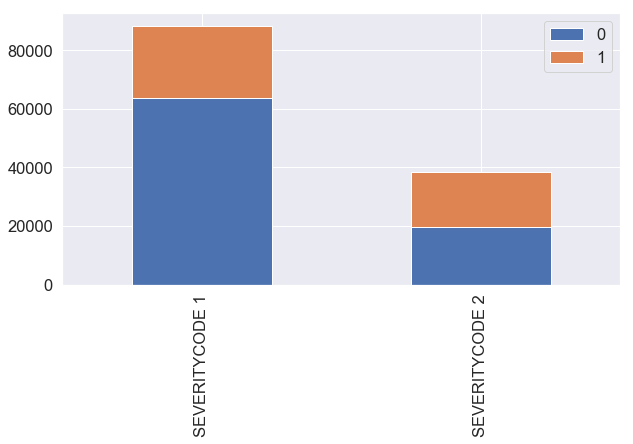

In [46]:
key = 'ADDRTYPE'
bar_chart(train, key)
CalculateZTest(train, key)

In [47]:
key = 'PERSONCOUNT'
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  0.0


reject null hypothesis, groups are different, pval  0.0


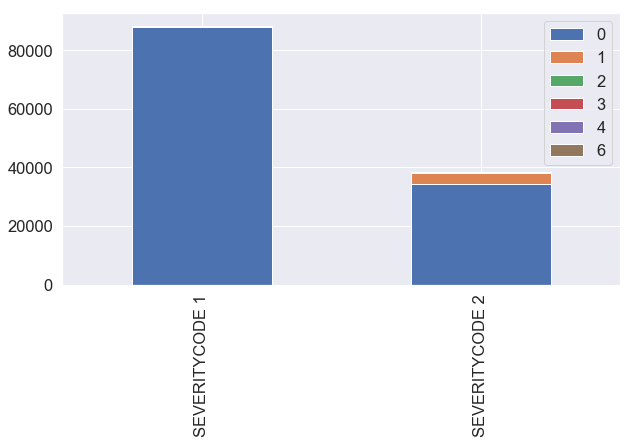

In [48]:
key = 'PEDCOUNT'
bar_chart(train, key)
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  0.0


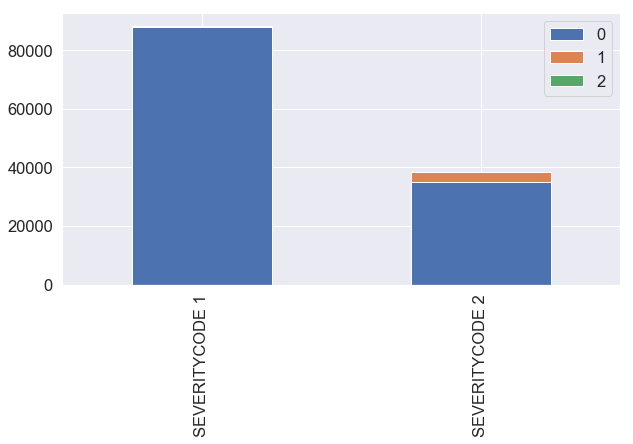

In [49]:
key = 'PEDCYLCOUNT'
bar_chart(train, key)
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  1.226117406830584e-97


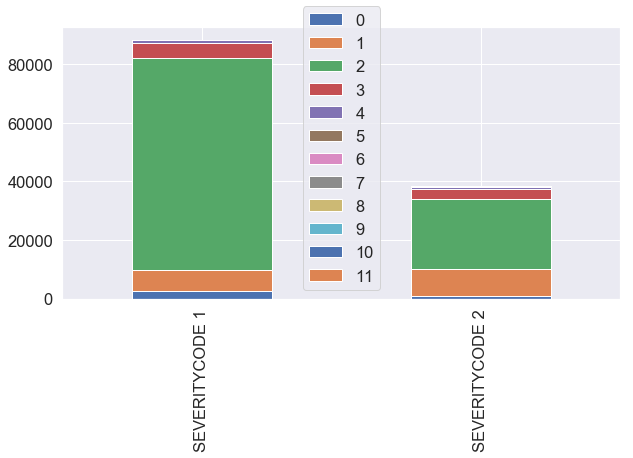

In [50]:
key = 'VEHCOUNT'
bar_chart(train, key)
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  0.0


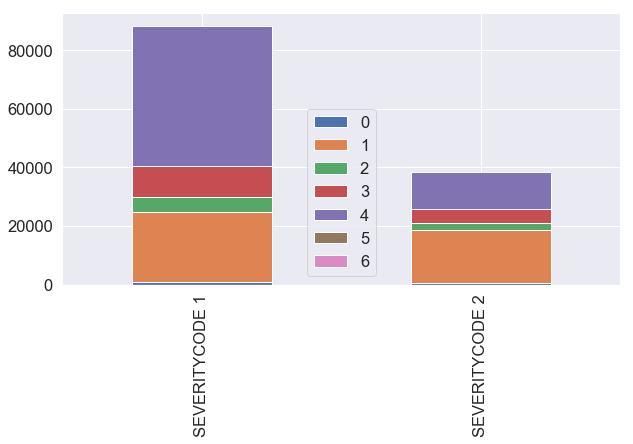

In [51]:
key = 'JUNCTIONTYPE'
bar_chart(train, key)
CalculateZTest(train, key)

In [52]:
#key = 'INATTENTIONIND'
#bar_chart(train, key)
#CalculateZTest(train, key)

In [53]:
#key = 'UNDERINFL'
#bar_chart(train, key)
#CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  0.0


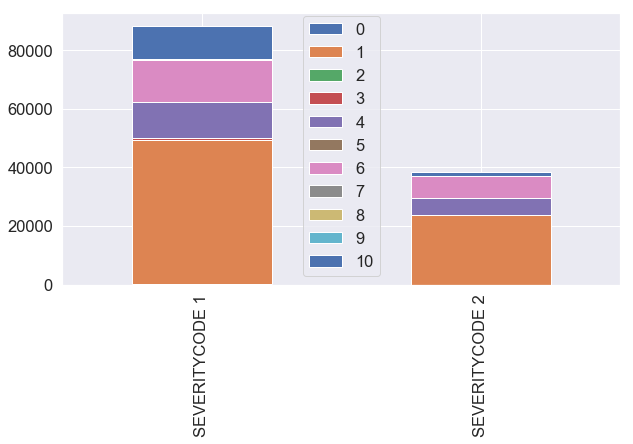

In [54]:
key = 'WEATHER'
bar_chart(train, key)
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  6.458500390186737e-71


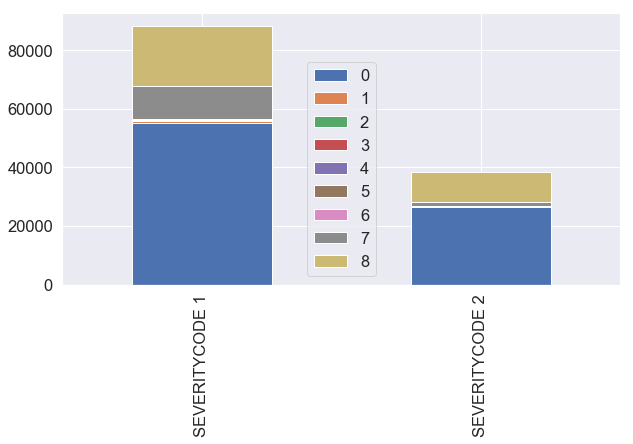

In [55]:
key = 'ROADCOND'
bar_chart(train, key)
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  3.7463622853906684e-112


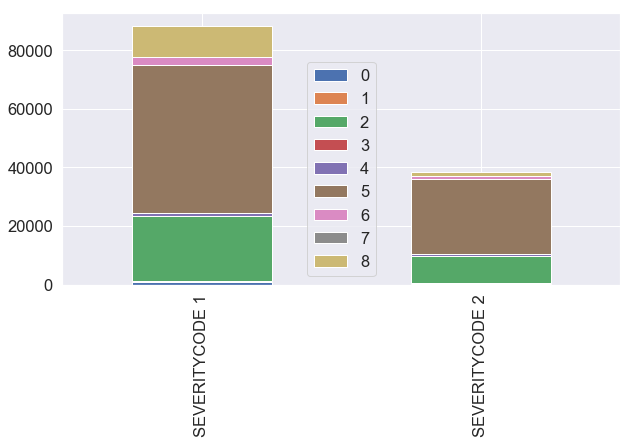

In [56]:
key = 'LIGHTCOND'
bar_chart(train, key)
CalculateZTest(train, key)

In [57]:
#key = 'PEDROWNOTGRNT'
#bar_chart(train, key)
#CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  2.0379919224168573e-38


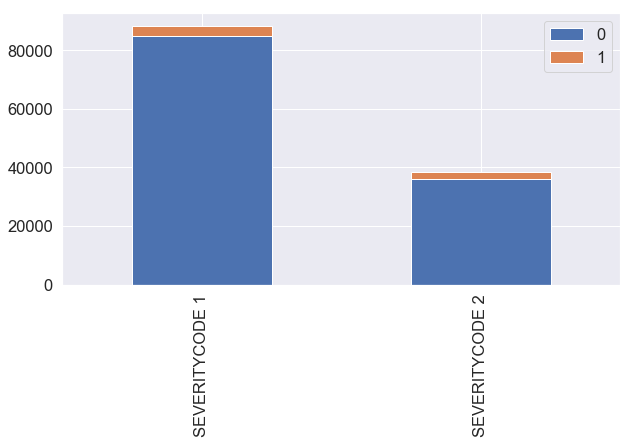

In [58]:
key = 'SPEEDING'
bar_chart(train, key)
CalculateZTest(train, key)

In [59]:
key = 'SEGLANEKEY'
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  0.0


In [60]:
key = 'CROSSWALKKEY'
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  0.0


reject null hypothesis, groups are different, pval  3.1017860335213858e-30


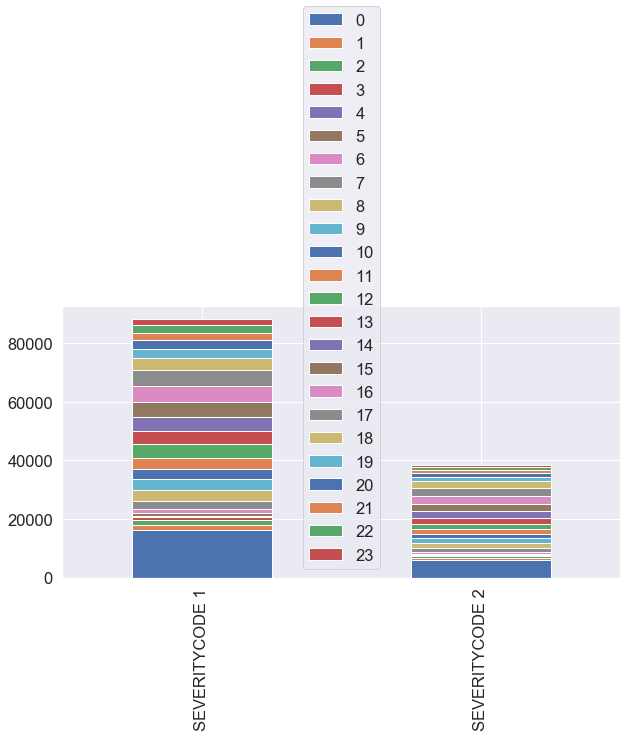

In [61]:
key = 'hour'
bar_chart(train, key)
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  2.033998104370034e-09


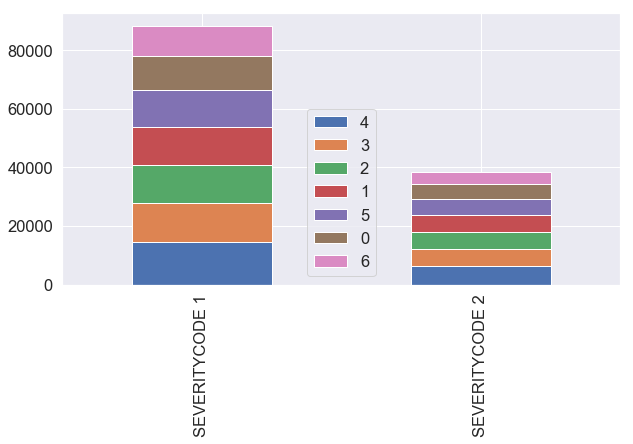

In [62]:
key = 'dayofweek'
bar_chart(train, key)
CalculateZTest(train, key)

accept null hypothesis, groups are not different, pval 0.46584493738477384


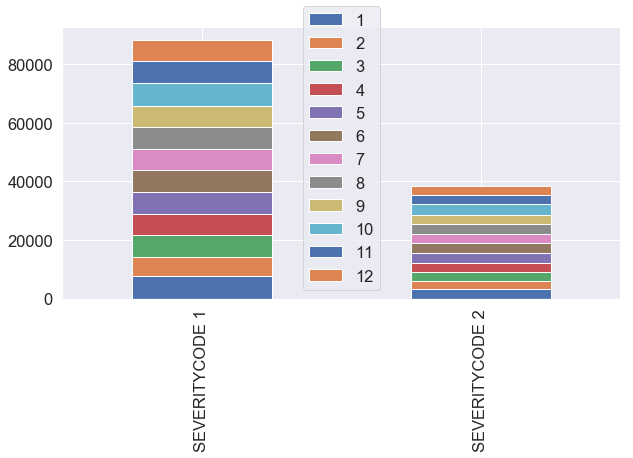

In [63]:
key = 'month'
bar_chart(train, key)
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  5.186112722854506e-16


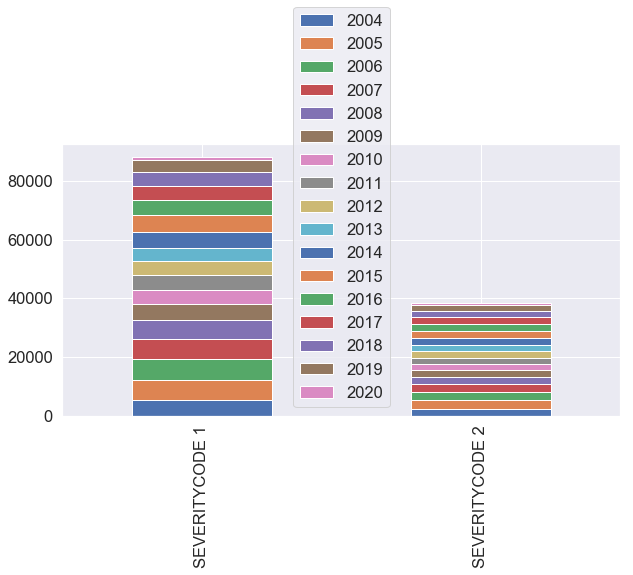

In [64]:
key = 'year'
bar_chart(train, key)
CalculateZTest(train, key)

When deviding by severity code only the feature month is not substantially different between the two groups, drop it

In [65]:
train = train.drop(['month'], axis=1)
test = test.drop(['month'], axis=1)

# Find high correlations

In [66]:
#df_numerical = test[['PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','SEGLANEKEY','CROSSWALKKEY','dayofweek','month','year']]

removed_columns=[]
correlation_threshold = 0.9
from scipy.stats import pearsonr
for c in train.columns:
    # correlation with pval
    for cc in train.columns:
        corrtest = pearsonr(train[c], train[cc])
        corr = corrtest[0]
        pval = corrtest[1]
        if cc != c and abs(corr) > correlation_threshold and pval < 0.05:
            print(c,' ', cc, ' correlation value ', float(corr))
            removed_columns.append([c,cc])

#print(removed_columns)
train = train.drop(['JUNCTIONTYPE'], axis=1)
test = test.drop(['JUNCTIONTYPE'], axis=1)

ADDRTYPE   JUNCTIONTYPE  correlation value  -0.922374850297305
JUNCTIONTYPE   ADDRTYPE  correlation value  -0.922374850297305


# Unbalance

In [67]:
len_total = len(train)
sel_1=train[train['SEVERITYCODE']==1]
len_1 = len(sel_1)
print(len_1/len_total)

len_total = len(test)
sel_1=test[test['SEVERITYCODE']==1]
len_1 = len(sel_1)
print(len_1/len_total)

0.6975144339749311
0.6974169147823288


# Save cleaned up dataframe

In [68]:
train.to_csv('Data-Collisions-train.csv')
test.to_csv('Data-Collisions-test.csv')

# Load cleaned dataframe

In [69]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [70]:
train = pd.read_csv('Data-Collisions-train.csv')
train = train.drop(['Unnamed: 0'], axis=1)
train.dropna(inplace=True)
details = computeDetails(train)
print(details)

                types  counts  distincts  nulls  missing ration
X             float64  126611      20683      0           0.000
Y             float64  126611      20923      0           0.000
ADDRTYPE        int64  126611          2      0           0.000
PERSONCOUNT     int64  126611         43      0           0.000
PEDCOUNT        int64  126611          6      0           0.000
PEDCYLCOUNT     int64  126611          3      0           0.000
VEHCOUNT        int64  126611         12      0           0.000
WEATHER         int64  126611         11      0           0.000
ROADCOND        int64  126611          9      0           0.000
LIGHTCOND       int64  126611          9      0           0.000
SPEEDING        int64  126611          2      0           0.000
SEGLANEKEY      int64  126611       1426      0           0.000
CROSSWALKKEY    int64  126611       1701      0           0.000
HITPARKEDCAR    int64  126611          2      0           0.000
SEVERITYCODE    int64  126611          2

In [71]:
test = pd.read_csv('Data-Collisions-test.csv')
test = test.drop(['Unnamed: 0'], axis=1)
test.dropna(inplace=True)
details = computeDetails(test)
print(details)

                types  counts  distincts  nulls  missing ration
X             float64   62135      16045      0           0.000
Y             float64   62135      16194      0           0.000
ADDRTYPE        int64   62135          2      0           0.000
PERSONCOUNT     int64   62135         33      0           0.000
PEDCOUNT        int64   62135          5      0           0.000
PEDCYLCOUNT     int64   62135          3      0           0.000
VEHCOUNT        int64   62135         13      0           0.000
WEATHER         int64   62135         10      0           0.000
ROADCOND        int64   62135          9      0           0.000
LIGHTCOND       int64   62135          9      0           0.000
SPEEDING        int64   62135          2      0           0.000
SEGLANEKEY      int64   62135        739      0           0.000
CROSSWALKKEY    int64   62135        956      0           0.000
HITPARKEDCAR    int64   62135          2      0           0.000
SEVERITYCODE    int64   62135          2

# Separate label and scale

In [72]:
y_train = train['SEVERITYCODE']
#y_train = [0 if v==1 else 1 for v in y_train]
X_train= train.drop(['SEVERITYCODE'], axis=1)

y_test= test['SEVERITYCODE']
#y_test = [0 if v==1 else 1 for v in y_test]
X_test= test.drop(['SEVERITYCODE'], axis=1)

In [73]:
from sklearn.preprocessing import StandardScaler

train_scaler = StandardScaler()
X_train_scaled = train_scaler.fit_transform(X_train)
X_test_scaled = train_scaler.transform(X_test)

X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train)
X_test_scaled = np.array(X_test_scaled)
y_test = np.array(y_test)

# Feature selection

In [74]:
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import chi2,f_classif
#def select_features(X_train, y_train, X_test):
#    fs = SelectKBest(score_func=f_classif, k='all')
#    fs.fit(X_train, y_train)
#    X_train_fs = fs.transform(X_train)
#    X_test_fs = fs.transform(X_test)
#    return X_train_fs, X_test_fs, fs

In [75]:
#X_train_fs, X_test_fs, fs = select_features(X_train_scaled, y_train, X_test_scaled)
#column_val =X_train.columns.values
#columns_to_drop=[]
#for i in range(len(fs.scores_)):
#    if fs.scores_[i]<200 and column_val[i]!='X' and column_val[i]!='Y':
#        print('Feature %s: %f' % (column_val[i], fs.scores_[i]))
#        columns_to_drop.append(column_val[i])

#X_train_scaled_selected = X_train.drop(columns_to_drop,axis=1)
#X_test_scaled_selected = X_test.drop(columns_to_drop,axis=1)

#train_scaler_selected = StandardScaler()
#X_train_scaled_selected = train_scaler_selected.fit_transform(X_train_scaled_selected)
#X_test_scaled_selected = train_scaler_selected.transform(X_test_scaled_selected)

In [76]:
#X_train_scaled = X_train_scaled_selected
#X_test_scaled = X_test_scaled_selected

In [77]:
#from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler()
#X_train_scaled, y_train = ros.fit_sample(X_train_scaled, y_train)

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report,confusion_matrix,f1_score,log_loss

# Define a function for grid search

In [79]:
import itertools
def GridSearchModelParameters(clf,parameters,X_train,y_train,fit_parameters=None):
    grid_search = GridSearchCV(clf, parameters, cv=3,return_train_score=True, scoring='neg_log_loss')
    if fit_parameters:
        grid_search.fit(X_train, y_train,**fit_parameters)
    else:
        grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    
def PlotConfusionMatrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Decision tree model

In [80]:
from sklearn.tree import DecisionTreeClassifier

In [81]:
parameters = {'criterion':['gini','entropy'],'max_depth':[5,6,8,10]}
clf = DecisionTreeClassifier(class_weight='balanced',random_state=42)

GridSearchModelParameters(clf,parameters,X_train_scaled,y_train)

{'criterion': 'gini', 'max_depth': 6}


In [82]:
tree_clf = DecisionTreeClassifier(criterion="gini",max_depth=6, class_weight='balanced',random_state=42)
tree_clf.fit(X_train_scaled, y_train) 
yhat = tree_clf.predict(X_test_scaled)

fscore = f1_score(y_test, yhat, average='weighted') 
print("f1score ",fscore)
from sklearn.metrics import accuracy_score
current_accuracy =  accuracy_score(y_test, yhat)
print("accuracy ", current_accuracy)

f1score  0.6355558162670842
accuracy  0.6209865615192726


Confusion matrix, without normalization
[[24222 19112]
 [ 4438 14363]]


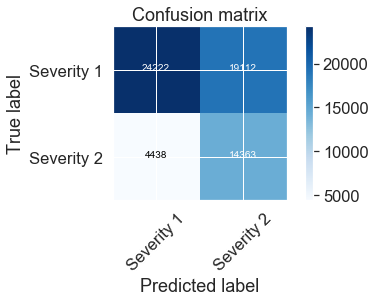

In [83]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2])
PlotConfusionMatrix(cnf_matrix, classes=['Severity 1','Severity 2'],normalize= False,  title='Confusion matrix')

# XGBoost

In [84]:
from sklearn.utils import class_weight
def ComputeWeights(y_val):
    sample_weights = class_weight.compute_class_weight('balanced', np.unique(y_val), y_val)
    weights = []
    y_train = np.array(y_val)
    for i in range(len(y_val)):
        if y_val[i] == 1:
            weights.append(sample_weights[0])
        elif y_val[i] == 2:
            weights.append(sample_weights[1])

    weights = np.array(weights)
    
    return weights

In [85]:
import xgboost as xgb

parameters = {'gamma':[0.05, 0.1,0.5],'max_depth':[4,8,16]}
clf = xgb.XGBClassifier(n_jobs=3,seed=42)

weights = ComputeWeights(y_train)
fit_parameters={'sample_weight':weights}

GridSearchModelParameters(clf,parameters,X_train_scaled,y_train,fit_parameters)

d:\apps\python_3_7_4\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[1 2], y=[1 1 1 ... 2 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{'gamma': 0.1, 'max_depth': 8}


In [99]:
xgboost_clf = xgb.XGBClassifier(n_jobs=3,seed=42, gamma = 0.1,max_depth=8)
xgboost_clf.fit(X_train_scaled, y_train,sample_weight=weights) 
yhat = xgboost_clf.predict(X_test_scaled)

fscore = f1_score(y_test, yhat, average='weighted') 
print("f1score ",fscore)
from sklearn.metrics import accuracy_score
current_accuracy =  accuracy_score(y_test, yhat)
print("accuracy ", current_accuracy)

f1score  0.6966331408576675
accuracy  0.6869236340226925


Confusion matrix, without normalization
[[30699 12635]
 [ 6818 11983]]


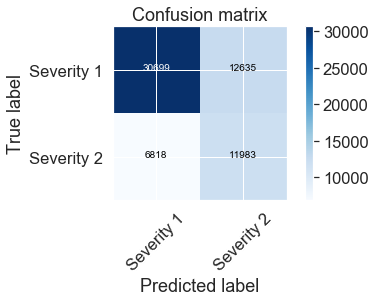

In [100]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2])
PlotConfusionMatrix(cnf_matrix, classes=['Severity 1','Severity 2'],normalize= False,  title='Confusion matrix')

# Random forest

In [88]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
parameters = {'criterion':['gini','entropy'],'max_depth':[2,3,4,5,6]}
clf = RandomForestClassifier(n_estimators = 100, class_weight='balanced',random_state=42)

GridSearchModelParameters(clf,parameters,X_train_scaled,y_train)

{'criterion': 'gini', 'max_depth': 6}


In [90]:
random_forest_clf = RandomForestClassifier(criterion="gini",max_depth=6, class_weight='balanced',random_state=42)
random_forest_clf.fit(X_train_scaled, y_train) 
yhat = random_forest_clf.predict(X_test_scaled)

fscore = f1_score(y_test, yhat, average='weighted') 
print("f1score ",fscore)
from sklearn.metrics import accuracy_score
current_accuracy =  accuracy_score(y_test, yhat)
print("accuracy ", current_accuracy)

f1score  0.6433591882247767
accuracy  0.6286794882111532


Confusion matrix, without normalization
[[24893 18441]
 [ 4631 14170]]


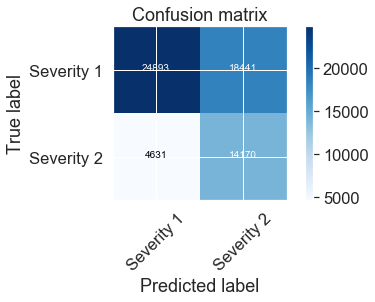

In [91]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2])
PlotConfusionMatrix(cnf_matrix, classes=['Severity 1','Severity 2'],normalize= False,  title='Confusion matrix')

# Voting classifier

In [101]:
from mlxtend.classifier import EnsembleVoteClassifier
models =[tree_clf,xgboost_clf,random_forest_clf]

voting_clf = EnsembleVoteClassifier(clfs=models, voting='soft',refit=False)
voting_clf.fit(X_train_scaled, y_train)
yhat = voting_clf.predict(X_test_scaled)

fscore = f1_score(y_test, yhat, average='weighted') 
print("f1score ",fscore)
from sklearn.metrics import accuracy_score
current_accuracy =  accuracy_score(y_test, yhat)
print("accuracy ", current_accuracy)

f1score  0.6910336926546061
accuracy  0.6796974330087713


Confusion matrix, without normalization
[[29714 13620]
 [ 6282 12519]]


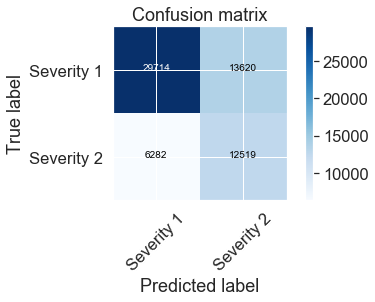

In [102]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2])
PlotConfusionMatrix(cnf_matrix, classes=['Severity 1','Severity 2'],normalize= False,  title='Confusion matrix')

# Feature selection

In [94]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=f_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [95]:
X_train_fs, X_test_fs, fs = select_features(X_train_scaled, y_train, X_test_scaled)
column_val =X_train.columns.values
columns_to_drop=[]
for i in range(len(fs.scores_)):
    print('Feature %s: %f' % (column_val[i], fs.scores_[i]))
    if fs.scores_[i]<100:
        columns_to_drop.append(column_val[i])

Feature X: 9.518745
Feature Y: 41.178305
Feature ADDRTYPE: 5293.562798
Feature PERSONCOUNT: 2026.176212
Feature PEDCOUNT: 8031.900705
Feature PEDCYLCOUNT: 6190.940665
Feature VEHCOUNT: 439.751488
Feature WEATHER: 1501.904765
Feature ROADCOND: 317.019483
Feature LIGHTCOND: 506.454543
Feature SPEEDING: 167.985344
Feature SEGLANEKEY: 1429.316901
Feature CROSSWALKKEY: 4113.620920
Feature HITPARKEDCAR: 1342.423050
Feature hour: 130.552753
Feature dayofweek: 35.940845
Feature year: 65.724351


In [96]:
#columns_to_drop=['month','dayofweek','SPEEDING']
X_train_scaled_selected = X_train.drop(columns_to_drop,axis=1)
X_test_scaled_selected = X_test.drop(columns_to_drop,axis=1)



In [97]:
train_scaler_selected = StandardScaler()
X_train_scaled_selected = train_scaler_selected.fit_transform(X_train_scaled_selected)
X_test_scaled_selected = train_scaler_selected.transform(X_test_scaled_selected)

In [98]:
clf = RandomForestClassifier(n_estimators=300,criterion='entropy')
clf.fit(X_train_scaled_selected, y_train)
yhat = clf.predict(X_test_scaled_selected)
fscore = f1_score(y_test, yhat, average='weighted') 
print(fscore)
current_accuracy =  accuracy_score(y_test, yhat)
print(current_accuracy)

0.7061353812292718
0.7417397601995654
